# Import Libraries & Load Data

##  Import Libraries

In [57]:
import numpy as np
import pandas as pd
import os 
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import time
import datetime 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
 
from collections import Counter 
from statistics import mode 
    
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
import ast 
tqdm.pandas()

import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
plotly.offline.init_notebook_mode(connected=True)

## Self-Defined Tools 

In [58]:
def value_counts_plot(df, name, xmin=False):
    
    plt.figure(figsize=[16,8])
    plt.subplot(1,2,1)
    df[name].value_counts().sort_index().plot()
    if xmin == True:
        plt.xlim(xmin = -100)
    plt.xlabel(name)
    plt.ylabel("Number of appearance")
    
    plt.subplot(1,2,2)
    df[name].value_counts().value_counts().sort_index().plot()
    if xmin == True:
        plt.xlim(xmin = -100)
    plt.xlabel('Number of appeareance of {}'.format(name))
    plt.ylabel('Number of appeareance of appearance')

## Load Data

In [59]:
path = './kdd2019/data/'

train_queries1 = pd.read_csv(path + 'train_queries_phase1.csv', parse_dates=['req_time'])
train_plans1   = pd.read_csv(path + 'train_plans_phase1.csv', parse_dates=['plan_time'])
train_clicks1  = pd.read_csv(path + 'train_clicks_phase1.csv')

train_queries2 = pd.read_csv(path + 'train_queries_phase2.csv', parse_dates=['req_time'])
train_plans2   = pd.read_csv(path + 'train_plans_phase2.csv', parse_dates=['plan_time'])
train_clicks2  = pd.read_csv(path + 'train_clicks_phase2.csv')

profiles      = pd.read_csv(path + 'profiles.csv') 

test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

In [60]:
train_plans   = pd.concat([train_plans1, train_plans2],axis=0,ignore_index=True)
train_queries = pd.concat([train_queries1, train_queries2],axis=0,ignore_index=True)
train_clicks  = pd.concat([train_clicks1, train_clicks2],axis=0,ignore_index=True)

# Single Variable Data Analysis

## train_plans data set

In [61]:
train_plans.head()

,sid,plan_time,plans
0,149233,2018-10-01 13:02:01,"[{""distance"": 2100, ""price"": 300, ""eta"": 1064,..."
1,337156,2018-11-23 10:48:25,"[{""distance"": 8887, ""price"": 400, ""eta"": 1631,..."
2,398930,2018-11-08 12:23:06,"[{""distance"": 8471, ""price"": 2300, ""eta"": 1284..."
3,196610,2018-11-27 12:11:59,"[{""distance"": 32405, ""price"": 2500, ""eta"": 477..."
4,302267,2018-10-18 17:22:19,"[{""distance"": 38511, ""price"": 700, ""eta"": 4715..."


### sid filed
1. Sid is unique

In [62]:
train_plans["sid"].value_counts()

2047       1
356868     1
1741304    1
1743353    1
1737210    1
          ..
709647     1
666640     1
664593     1
670738     1
0          1
Name: sid, Length: 1938572, dtype: int64

### plan_time filed
1. 请求编号每天都在变化, 有两天2018-10-09和2018-11-05的请求时间少于6000次，其他几天至少有20000+次请求;
2. 由于国庆节，2018-10-01至2018-10-07之间有更多请求，特别是在2018-10-01-2018-10-03。
3. 每个工作日的分布是不同的，看起来周五，周六和周日有更多要求。

In [63]:
train_plans["plan_time"] = pd.to_datetime(train_plans["plan_time"])
train_plans["plan_time_date"] = train_plans["plan_time"].dt.date
train_plans["plan_time_dow"] = train_plans["plan_time"].dt.weekday

In [64]:
train_plans["plan_time_date"].value_counts().sort_values()

2018-10-09     5555
2018-11-05     5929
2018-10-15    20172
2018-11-30    24401
2018-10-08    26010
2018-11-12    26228
2018-11-13    26929
2018-11-28    27038
2018-10-10    27093
2018-11-14    27258
2018-11-27    27372
2018-11-08    27802
2018-11-06    27906
2018-11-15    27947
2018-11-19    28063
2018-11-29    28072
2018-11-26    28101
2018-11-07    28388
2018-10-22    28809
2018-10-23    28884
2018-10-11    28942
2018-10-30    29282
2018-10-18    29407
2018-10-29    29424
2018-11-20    29467
2018-10-24    29488
2018-10-16    29570
2018-11-21    29700
2018-10-25    29824
2018-11-01    29885
2018-10-17    29924
2018-10-31    29996
2018-11-22    31042
2018-10-04    31153
2018-11-11    32730
2018-11-02    33562
2018-11-16    33791
2018-10-12    33917
2018-10-14    34509
2018-11-09    34557
2018-11-04    34845
2018-10-19    35281
2018-11-18    35293
2018-11-25    35832
2018-10-26    35860
2018-10-07    35914
2018-11-23    36567
2018-10-21    36940
2018-10-28    37237
2018-11-10    38865


Text(0, 0.5, 'Number of appeareance')

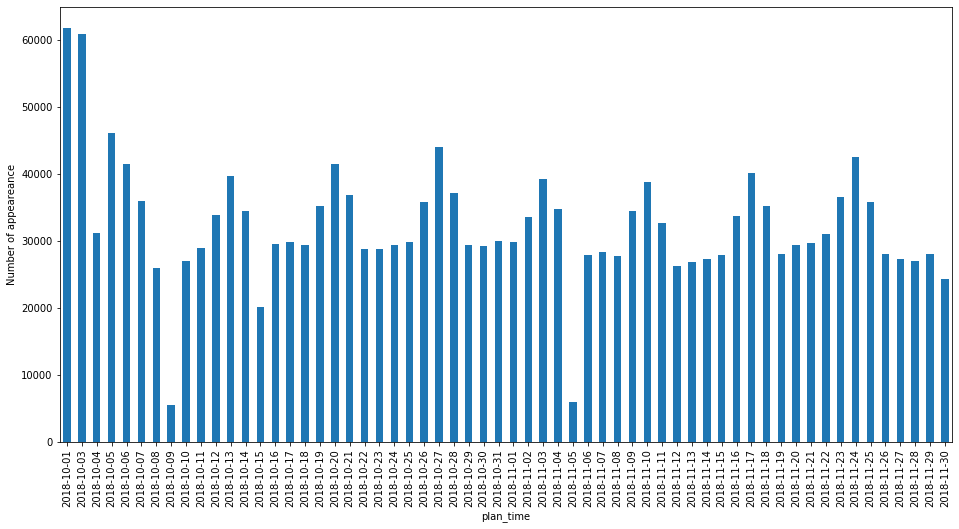

In [65]:
plt.figure(figsize=[16,8])
train_plans["plan_time_date"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('plan_time')
plt.ylabel('Number of appeareance') 

有两天2018-10-09和2018-11-05的请求时间少于6000次

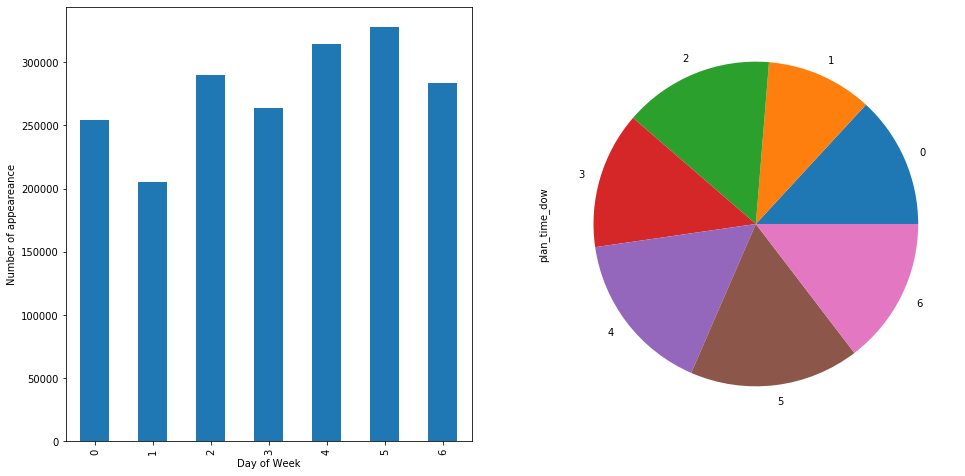

In [66]:
plt.figure(figsize=[16,8])
plt.subplot(1,2,1)
train_plans["plan_time_dow"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('Day of Week')
plt.ylabel('Number of appeareance')
plt.subplot(1, 2, 2)
train_plans['plan_time_dow'].value_counts().sort_index().plot(kind = 'pie') 

每个工作日的分布是不同的，看起来周五，周六和周日有更多要求

In [67]:
train_plans.head()

,sid,plan_time,plans,plan_time_date,plan_time_dow
0,149233,2018-10-01 13:02:01,"[{""distance"": 2100, ""price"": 300, ""eta"": 1064,...",2018-10-01,0
1,337156,2018-11-23 10:48:25,"[{""distance"": 8887, ""price"": 400, ""eta"": 1631,...",2018-11-23,4
2,398930,2018-11-08 12:23:06,"[{""distance"": 8471, ""price"": 2300, ""eta"": 1284...",2018-11-08,3
3,196610,2018-11-27 12:11:59,"[{""distance"": 32405, ""price"": 2500, ""eta"": 477...",2018-11-27,1
4,302267,2018-10-18 17:22:19,"[{""distance"": 38511, ""price"": 700, ""eta"": 4715...",2018-10-18,3


In [68]:
# 排除掉国庆7天以及2018-10-09和2018-11-05两天较少的请求
tmp = train_plans.loc[((train_plans['plan_time_date'] >= datetime.date(2018,10,7)) & (train_plans['plan_time_date'] != datetime.date(2018,10,9)) & (train_plans['plan_time_date'] != datetime.date(2018,11,5)))].groupby('plan_time_date')['plan_time'].agg([('plan_time_count','count')]).reset_index()
tmp["plan_time_dow"] = pd.to_datetime(tmp["plan_time_date"]).dt.weekday

In [69]:
# datetime.date(2018,10,1)

In [70]:
tmp.head()

,plan_time_date,plan_time_count,plan_time_dow
0,2018-10-07,35914,6
1,2018-10-08,26010,0
2,2018-10-10,27093,2
3,2018-10-11,28942,3
4,2018-10-12,33917,4


同一星期的日期进行mean操作, 每个星期平均多少请求

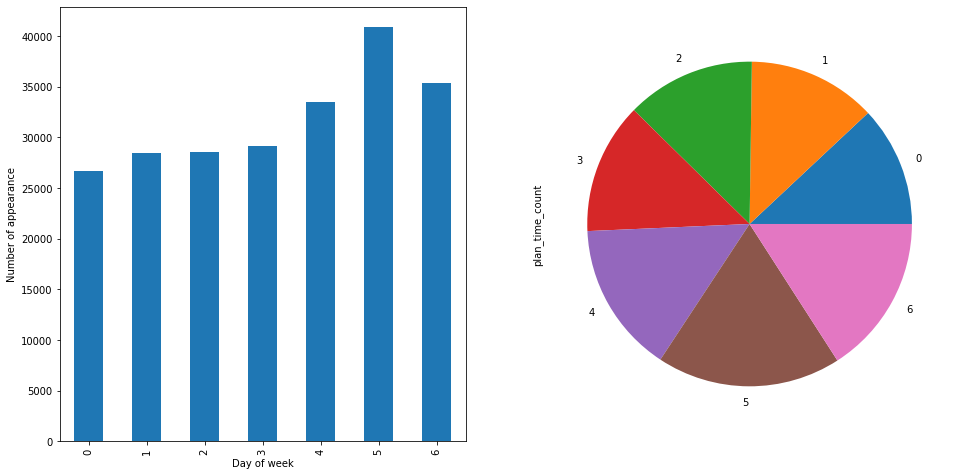

In [71]:
plt.figure(figsize=[16,8])
plt.subplot(121)
tmp.groupby("plan_time_dow")["plan_time_count"].mean().sort_index().plot(kind="bar")
plt.xlabel("Day of week")
plt.ylabel("Number of appearance")
plt.subplot(122)
tmp.groupby('plan_time_dow')['plan_time_count'].mean().sort_index().plot(kind = 'pie')

### plans field

In [72]:
# ast.literal_eval 处理抽象语法解析，在这作为对字符串类型转换。例如 字符串型的字典转换为字典，相当于eval
train_plans["plans"] = train_plans["plans"].fillna("[]").apply(ast.literal_eval)

In [73]:
train_plans["plans"][0]

[{'distance': 2100, 'price': 300, 'eta': 1064, 'transport_mode': 2},
 {'distance': 2577, 'price': '', 'eta': 461, 'transport_mode': 3},
 {'distance': 2577, 'price': 1300, 'eta': 461, 'transport_mode': 4},
 {'distance': 1720, 'price': '', 'eta': 518, 'transport_mode': 6},
 {'distance': 1645, 'price': '', 'eta': 1438, 'transport_mode': 5},
 {'distance': 1729, 'price': 200, 'eta': 1482, 'transport_mode': 1}]

In [76]:
def _plans_trans(df):
    df_plans_pivot   = pd.DataFrame()
    sids             = []
    prices           = []
    distances        = []
    etas             = []
    transport_modes  = []
    ranks            = []   
    plan_times       = []
    for sid, plan_time, plans in tqdm(df[["sid", "plan_time", "plans"]].values):
        for i, plan in enumerate(plans):
            sids.append(sid)
            transport_modes.append(plan["transport_mode"])
            distances.append(plan["distance"])
            etas.append(plan["eta"])
            prices.append(plan["price"])
            plan_times.append(plan_time)
            ranks.append(i) # 计划列表里排名
    df_plans_pivot["sid"]             = sids
    df_plans_pivot['price']           = prices
    df_plans_pivot['distance']        = distances
    df_plans_pivot['transport_mode']  = transport_modes
    df_plans_pivot['ranks']           = ranks
    df_plans_pivot['plan_time']       = plan_times 
    df_plans_pivot['etas']            = etas
    df_plans_pivot["price"]           = df_plans_pivot["price"].apply(lambda x: 0 if x == "" else float(x))
    return df_plans_pivot
    
    

In [77]:
%%time
plans_pivot = _plans_trans(train_plans)
plans_pivot["speed"] = plans_pivot["distance"] / plans_pivot["etas"]

100%|█████████████████████████████████████████████████████████████████████| 1938572/1938572 [03:04<00:00, 10521.90it/s]


Wall time: 13min 3s


In [78]:
plans_pivot.head()

,sid,price,distance,transport_mode,ranks,plan_time,etas,speed
0,149233,300.0,2100,2,0,2018-10-01 13:02:01,1064,1.973684
1,149233,0.0,2577,3,1,2018-10-01 13:02:01,461,5.590022
2,149233,1300.0,2577,4,2,2018-10-01 13:02:01,461,5.590022
3,149233,0.0,1720,6,3,2018-10-01 13:02:01,518,3.320463
4,149233,0.0,1645,5,4,2018-10-01 13:02:01,1438,1.143950


#### transport_mode
- 选择交通方式3最频繁，其次是4,1,3。
- 交通方式8和11的频率最低。

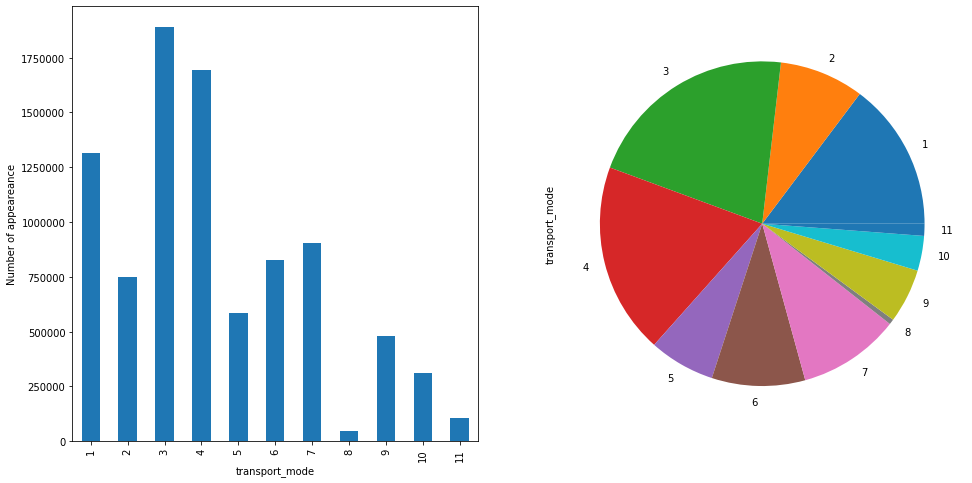

In [79]:
plt.figure(figsize=[16,8])
plt.subplot(1, 2, 1)
plans_pivot["transport_mode"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('transport_mode')
plt.ylabel('Number of appeareance')
plt.subplot(1, 2, 2)
plans_pivot['transport_mode'].value_counts().sort_index().plot(kind = 'pie') 

#### distance
- 距离变化很大，最小距离为1，最大距离为225000，这个差距非常大。
- 大约95％的距离小于50000

In [81]:
plans_pivot["distance"].describe(percentiles = [0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1])

count    8.906188e+06
mean     1.618052e+04
std      1.580115e+04
min      1.000000e+00
0%       1.000000e+00
5%       8.970000e+02
10%      1.708000e+03
20%      3.400000e+03
30%      5.430000e+03
40%      8.134000e+03
50%      1.134500e+04
60%      1.541500e+04
70%      2.023300e+04
80%      2.666600e+04
90%      3.732500e+04
95%      4.739700e+04
100%     2.258640e+05
max      2.258640e+05
Name: distance, dtype: float64

Text(0.5, 0, 'distance')

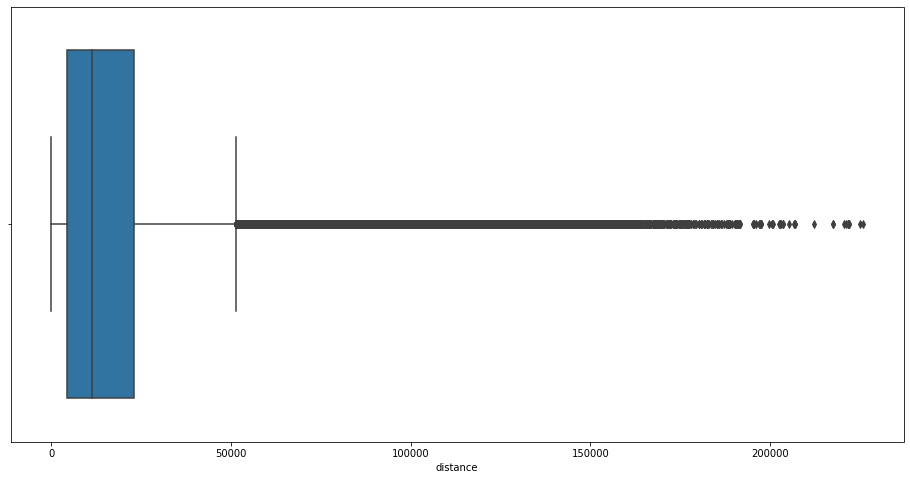

In [82]:
# boxplot箱形图,显示一组数据分散情况资料的统计图
# 参考 https://blog.csdn.net/qq_39949963/article/details/79387486
plt.figure(figsize=[16,8])
sns.boxplot(plans_pivot["distance"])
plt.xlabel("distance")

#### etas 预计到达时间
- eta值相差很大，etas的最小值为1，最大值为72992
- 大约95％的etas小于6500，

In [84]:
plans_pivot['etas'].describe(percentiles = [0,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1])

count    8.906188e+06
mean     2.709388e+03
std      1.957669e+03
min      1.000000e+00
0%       1.000000e+00
5%       3.390000e+02
10%      6.430000e+02
20%      1.140000e+03
30%      1.556000e+03
40%      1.951000e+03
50%      2.348000e+03
60%      2.767000e+03
70%      3.263000e+03
80%      3.950000e+03
90%      5.152000e+03
95%      6.405000e+03
100%     7.299200e+04
max      7.299200e+04
Name: etas, dtype: float64

Text(0.5, 0, 'etas')

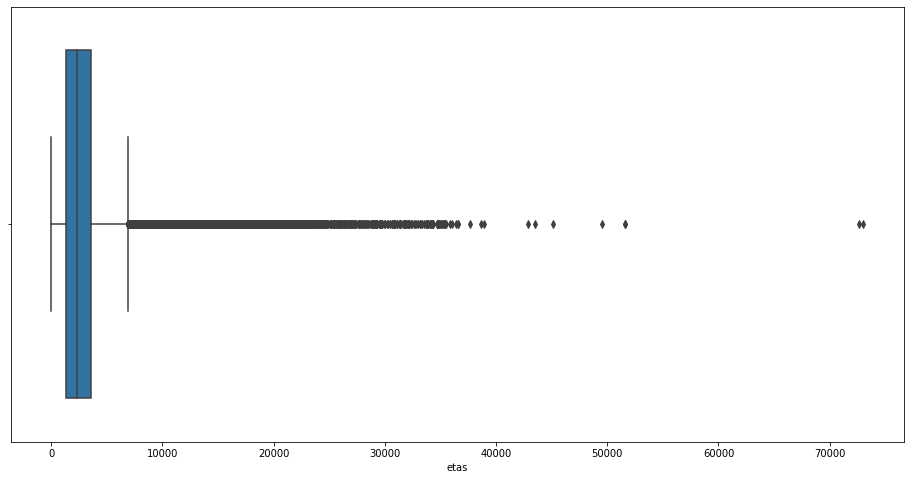

In [85]:
plt.figure(figsize=[16,8]) 
sns.boxplot(plans_pivot['etas'])
plt.xlabel('etas')

#### 推荐运输方式
- 大多数计划建议使用4或5或6个不同的计划，有些仅建议1个计划，占约1.8％。

In [86]:
plans_pivot.head()

,sid,price,distance,transport_mode,ranks,plan_time,etas,speed
0,149233,300.0,2100,2,0,2018-10-01 13:02:01,1064,1.973684
1,149233,0.0,2577,3,1,2018-10-01 13:02:01,461,5.590022
2,149233,1300.0,2577,4,2,2018-10-01 13:02:01,461,5.590022
3,149233,0.0,1720,6,3,2018-10-01 13:02:01,518,3.320463
4,149233,0.0,1645,5,4,2018-10-01 13:02:01,1438,1.143950


In [91]:
tmp = plans_pivot.groupby("sid")["ranks"].max().to_frame()

In [92]:
# 每个会话sid生成的运输计划个数
tmp["ranks"] = tmp["ranks"] + 1
tmp["ranks"].value_counts(normalize=True) # 以百分比的形式显示

5    0.330529
4    0.268247
6    0.201649
3    0.165452
7    0.019170
2    0.013154
1    0.001796
8    0.000003
Name: ranks, dtype: float64

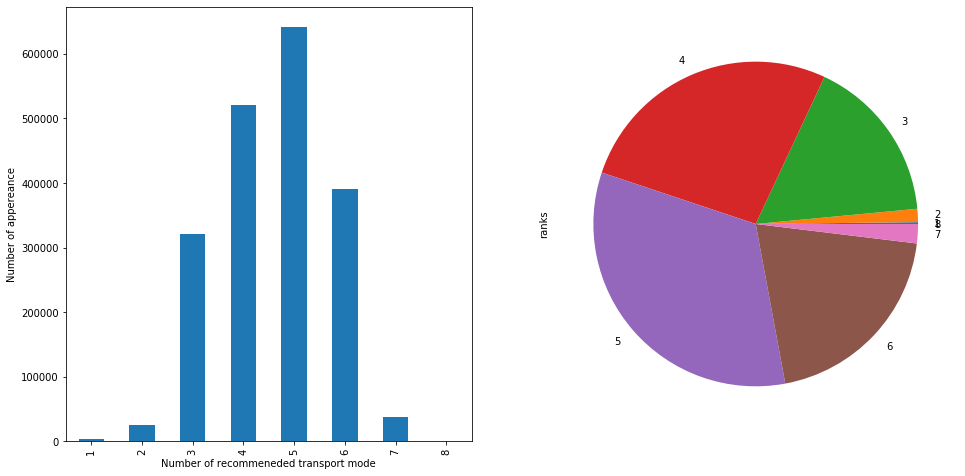

In [93]:
plt.figure(figsize=[16,8]) 
plt.subplot(1, 2, 1)
tmp['ranks'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Number of recommeneded transport mode')
plt.ylabel('Number of appereance')
plt.subplot(1, 2, 2)
tmp['ranks'].value_counts().sort_index().plot(kind = 'pie') 

推送计划最多的数量为5个左右

## train_queries data set
### sid filed
1. Sid is unique

In [94]:
train_queries.head()

,sid,pid,req_time,o,d
0,419087,22813.0,2018-10-17 10:17:11,"116.34,39.99","116.37,39.86"
1,481938,NaN,2018-10-13 15:50:15,"116.43,39.94","116.46,39.95"
2,441201,34393.0,2018-10-13 16:15:21,"116.28,40.01","116.39,39.99"
3,347266,NaN,2018-10-22 13:26:04,"116.31,39.51","116.32,39.72"
4,206269,NaN,2018-11-08 10:27:23,"116.33,39.89","116.59,39.76"


In [95]:
train_queries["sid"].value_counts()

2047       1
1669509    1
1665415    1
1642888    1
1644937    1
          ..
582729     1
588874     1
586827     1
576588     1
0          1
Name: sid, Length: 2000000, dtype: int64

### pid filed
1.有676803个缺失的pid值，占33.84％；  
2.最常见的pid是8645，约占1.125％。   
3.大约36.4％的pid仅搜索一次。   

In [96]:
# 缺失值填充为-1
train_queries["pid"].fillna(-1 ,inplace=True)

In [97]:
train_queries['pid'].value_counts()

-1.0         676803
 8645.0       22503
 51133.0      18588
 11803.0      13858
 29160.0      10314
              ...  
 96188.0          1
 23856.0          1
 6012.0           1
 23852.0          1
 131068.0         1
Name: pid, Length: 97372, dtype: int64

In [98]:
train_queries["pid"].value_counts(normalize=True)

-1.0         3.384015e-01
 8645.0      1.125150e-02
 51133.0     9.294000e-03
 11803.0     6.929000e-03
 29160.0     5.157000e-03
                 ...     
 96188.0     5.000000e-07
 23856.0     5.000000e-07
 6012.0      5.000000e-07
 23852.0     5.000000e-07
 131068.0    5.000000e-07
Name: pid, Length: 97372, dtype: float64

Text(0, 0.5, 'Number of appearance')

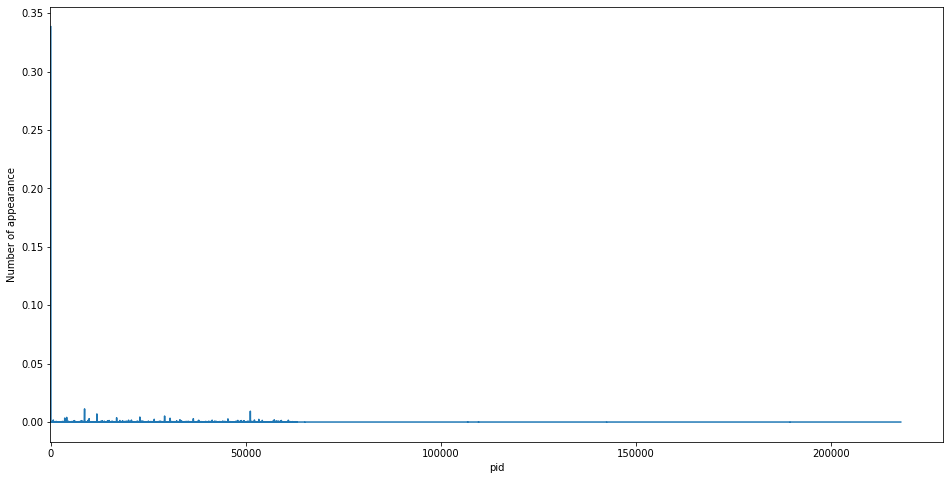

In [99]:
plt.figure(figsize=[16,8])
train_queries['pid'].fillna(-1).value_counts(normalize = True).sort_index().plot()
plt.xlim(xmin=-100)
plt.xlabel("pid")
plt.ylabel("Number of appearance")

In [101]:
# 大约36.4％的pid仅搜索一次
train_queries['pid'].value_counts().value_counts(normalize = True)

1       0.363914
2       0.152857
3       0.088793
4       0.060151
5       0.043452
          ...   
564     0.000010
474     0.000010
922     0.000010
1370    0.000010
1279    0.000010
Name: pid, Length: 642, dtype: float64

### o field
1.我们有14807个不同的o值；  
2.最常见的o是113.32,23.13，没有o可以占到1％以上。   
3.在不同的省份，它们都有热门和冷门的地方。  

In [102]:
train_queries["o"].fillna(-1, inplace=True)

In [103]:
train_queries["o"].nunique()

14807

In [104]:
train_queries["o"].value_counts()

113.32,23.13    10442
121.48,31.24     9940
121.45,31.25     9142
121.47,31.24     8527
113.25,23.15     8195
                ...  
121.51,31.60        1
116.66,40.65        1
113.50,23.63        1
116.95,40.18        1
121.67,30.96        1
Name: o, Length: 14807, dtype: int64

In [105]:
train_queries['o'].value_counts(normalize = True)

113.32,23.13    5.221000e-03
121.48,31.24    4.970000e-03
121.45,31.25    4.571000e-03
121.47,31.24    4.263500e-03
113.25,23.15    4.097500e-03
                    ...     
121.51,31.60    5.000000e-07
116.66,40.65    5.000000e-07
113.50,23.63    5.000000e-07
116.95,40.18    5.000000e-07
121.67,30.96    5.000000e-07
Name: o, Length: 14807, dtype: float64

Text(0, 0.5, 'Percentage of apperance')

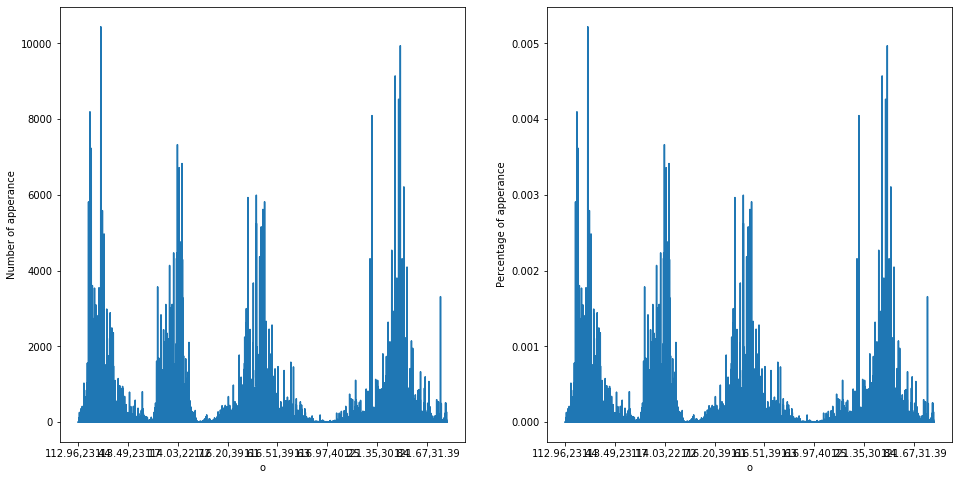

In [106]:
plt.figure(figsize=[16,8]) 
plt.subplot(1, 2, 1)
train_queries['o'].value_counts().sort_index().plot()
plt.xlabel('o')
plt.ylabel('Number of apperance')
plt.subplot(1, 2, 2)
train_queries['o'].value_counts(normalize = True).sort_index().plot()  
plt.xlabel('o')
plt.ylabel('Percentage of apperance')

### d field
1.共13445个不同的o值；   
2.最频繁的d是121.32,31.20，除121.32,31.20外，没有其他d可以占到1％以上。   
3.在不同的省份，它们都有热门和冷门的地方。 

In [107]:
train_queries['d'].fillna(-1,inplace = True)  
train_queries['d'].nunique()

13445

In [108]:
train_queries['d'].value_counts()

121.32,31.20    23088
116.32,39.89    16503
113.26,22.99    14951
121.45,31.25    14384
116.37,39.86    13124
                ...  
115.99,39.79        1
116.78,39.72        1
113.63,23.29        1
116.47,39.69        1
113.69,23.26        1
Name: d, Length: 13445, dtype: int64

In [109]:
train_queries['d'].value_counts(normalize = True)

121.32,31.20    1.154400e-02
116.32,39.89    8.251500e-03
113.26,22.99    7.475500e-03
121.45,31.25    7.192000e-03
116.37,39.86    6.562000e-03
                    ...     
115.99,39.79    5.000000e-07
116.78,39.72    5.000000e-07
113.63,23.29    5.000000e-07
116.47,39.69    5.000000e-07
113.69,23.26    5.000000e-07
Name: d, Length: 13445, dtype: float64

Text(0, 0.5, 'Percentage of apperance')

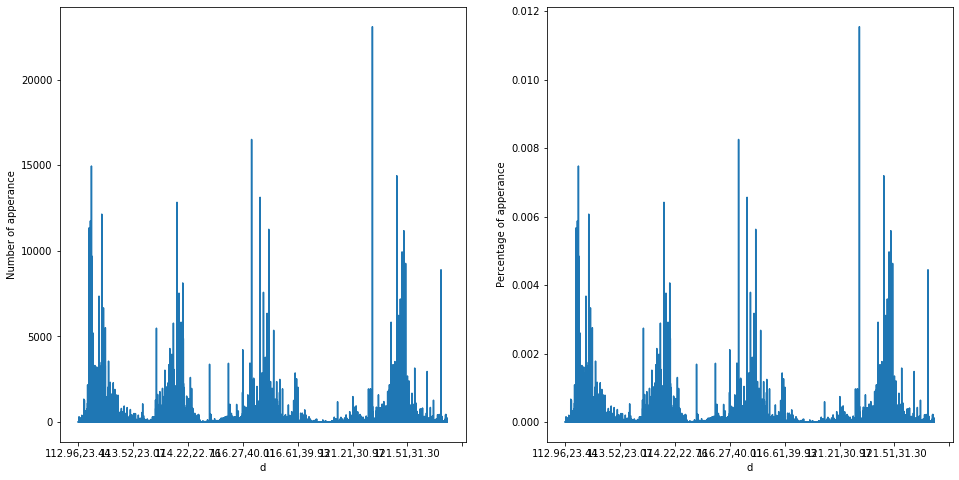

In [110]:
plt.figure(figsize=[16,8]) 
plt.subplot(1, 2, 1)
train_queries['d'].value_counts().sort_index().plot()
plt.xlabel('d')
plt.ylabel('Number of apperance')
plt.subplot(1, 2, 2)
train_queries['d'].value_counts(normalize = True).sort_index().plot()  
plt.xlabel('d')
plt.ylabel('Percentage of apperance')

### req_time filed
1.请求数量每天都在变化，有两天2018-10-09和2018-11-05的请求时间少于7000次，其他几天至少有20000+次请求；   
2.在2018-10-01至2018-10-07之间有更多请求，特别是在国庆节期间，尤其是在2018-10-01和2018-10-03。   
3.每个工作日的分配是不同的，看起来周五，周六和周日有更多要求。

In [111]:
train_queries['req_time']      = pd.to_datetime(train_queries['req_time'])
train_queries['req_time_date'] = train_queries['req_time'].dt.date
train_queries['req_time_dow'] = train_queries['req_time'].dt.weekday

In [113]:
train_queries['req_time_date'].value_counts().sort_values()

2018-10-09     6596
2018-11-05     6897
2018-10-15    21165
2018-11-30    25381
2018-10-08    27068
2018-11-12    27108
2018-11-28    27870
2018-11-13    27887
2018-10-10    28102
2018-11-14    28217
2018-11-27    28232
2018-11-08    28789
2018-11-06    28861
2018-11-15    28901
2018-11-29    28927
2018-11-19    28992
2018-11-26    29047
2018-11-07    29299
2018-10-22    29808
2018-10-23    29890
2018-10-11    29976
2018-10-30    30258
2018-10-18    30346
2018-10-29    30398
2018-11-20    30407
2018-10-24    30535
2018-10-16    30553
2018-11-21    30763
2018-10-25    30828
2018-11-01    30947
2018-10-17    30964
2018-10-31    30992
2018-11-22    32000
2018-10-04    32302
2018-11-11    33548
2018-11-02    34665
2018-11-16    34875
2018-10-12    35089
2018-10-14    35569
2018-11-09    35586
2018-11-04    35843
2018-11-18    36209
2018-10-19    36467
2018-11-25    36765
2018-10-26    37046
2018-10-07    37048
2018-11-23    37570
2018-10-21    38039
2018-10-28    38332
2018-11-10    39808


Text(0, 0.5, 'Number of appeareance')

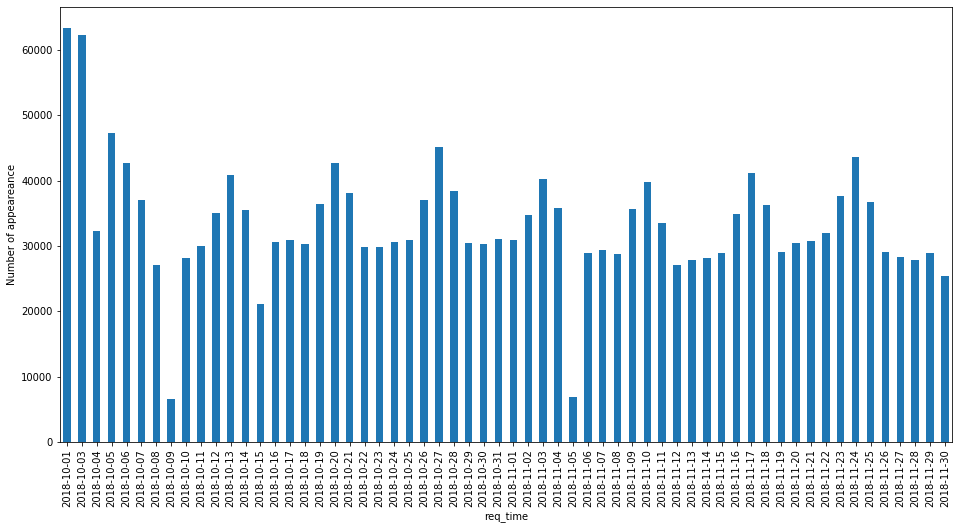

In [114]:
plt.figure(figsize=[16,8]) 
train_queries['req_time_date'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('req_time')
plt.ylabel('Number of appeareance') 

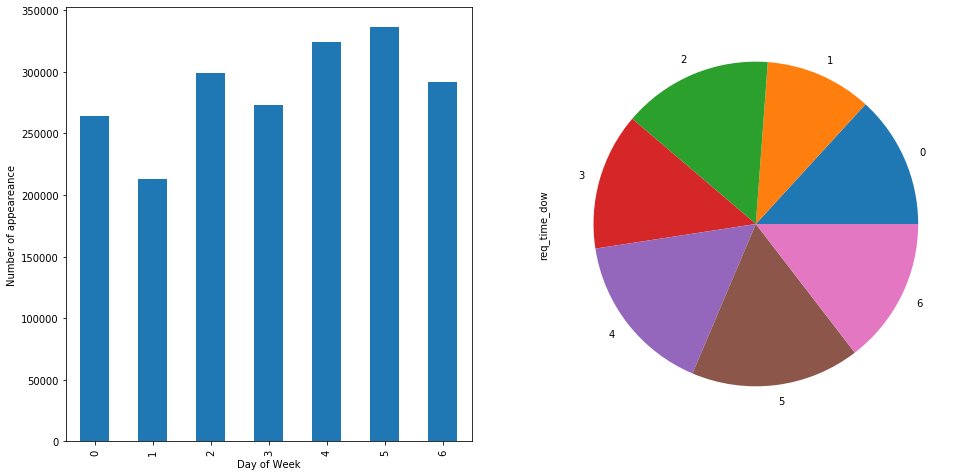

In [115]:
plt.figure(figsize=[16,8]) 
plt.subplot(1, 2, 1)
train_queries['req_time_dow'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of appeareance')
plt.subplot(1, 2, 2)
train_queries['req_time_dow'].value_counts().sort_index().plot(kind = 'pie') 

In [118]:
tmp = train_queries.loc[((train_queries['req_time_date'] >= datetime.date(2018,10,7)) & (train_queries['req_time_date'] != datetime.date(2018,10,9)) & (train_queries['req_time_date'] != datetime.date(2018,11,5)))].groupby('req_time_date')['req_time'].agg([('req_time_count','count')]).reset_index()
tmp['req_time_dow'] = pd.to_datetime(tmp['req_time_date']).dt.weekday

以天为单位，当天请求的总数

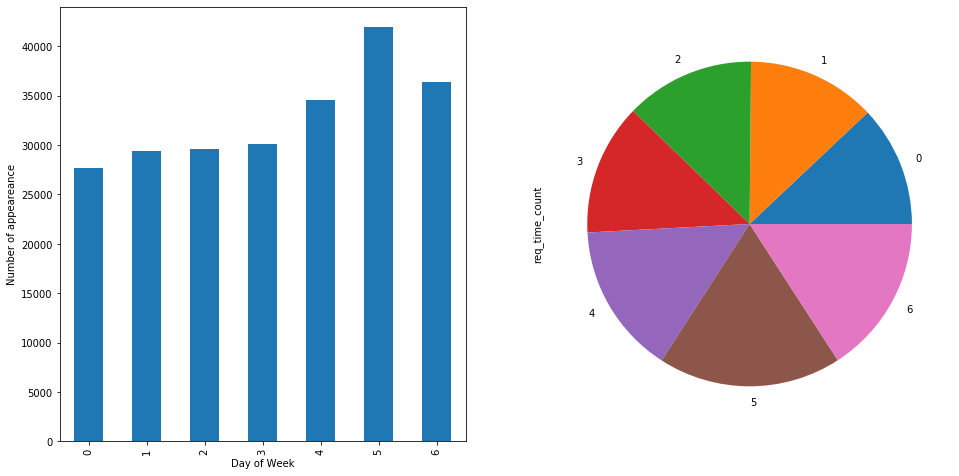

In [119]:
plt.figure(figsize=[16,8]) 
plt.subplot(121)
tmp.groupby('req_time_dow')['req_time_count'].mean().sort_index().plot(kind = 'bar')
plt.xlabel('Day of Week')
plt.ylabel('Number of appeareance')
plt.subplot(122)
tmp.groupby('req_time_dow')['req_time_count'].mean().sort_index().plot(kind = 'pie')

星期几的平均请求数量

## train_clicks data set
### sid filed
1. Sid is unique

In [120]:
train_clicks.head()

,sid,click_time,click_mode
0,175043,2018-10-14 10:35:07,7
1,414568,2018-10-20 04:18:48,2
2,314669,2018-10-26 16:53:04,2
3,117837,2018-10-03 18:48:02,7
4,474691,2018-11-01 15:59:01,2


In [121]:
train_clicks['sid'].value_counts()

2047      1
41662     1
62132     1
64181     1
58038     1
         ..
898275    1
888036    1
885989    1
892134    1
0         1
Name: sid, Length: 1675183, dtype: int64

### click_mode
- The click_mode 2 is the most frequent, which occupies 27.83%, followed by 1,7,9.
- the click_mode 8 and 11 are the least frequent.

In [122]:
train_clicks["click_mode"].value_counts(normalize=True)

2     0.278284
7     0.171121
1     0.163761
9     0.122579
5     0.111828
3     0.049663
10    0.030849
4     0.024825
6     0.023975
11    0.019001
8     0.004115
Name: click_mode, dtype: float64

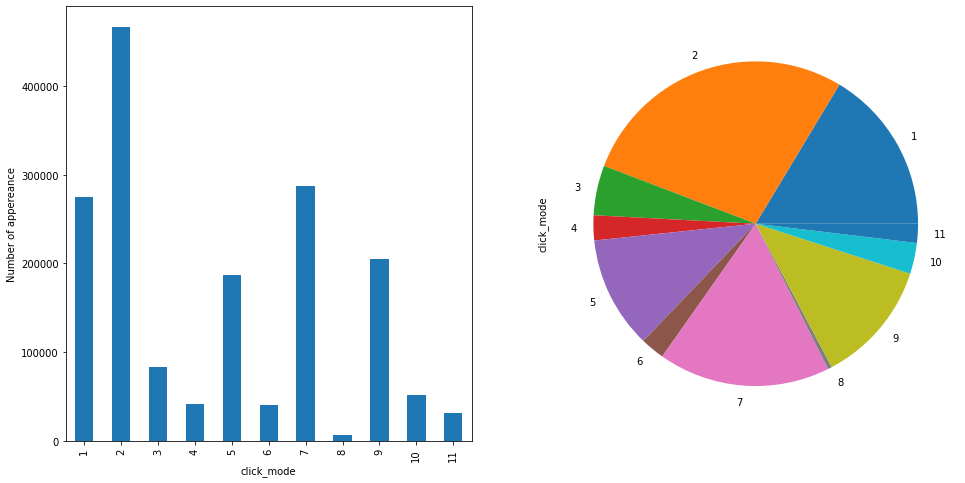

In [123]:
plt.figure(figsize=[16,8]) 
plt.subplot(1, 2, 1)
train_clicks['click_mode'].value_counts().sort_index().plot(kind = 'bar')
plt.xlabel('click_mode')
plt.ylabel('Number of appereance')
plt.subplot(1, 2, 2)
train_clicks['click_mode'].value_counts().sort_index().plot(kind = 'pie') 

In [125]:
train_clicks['click_mode'].nunique()

11

## profiles data set
### pid filed
1. pid is unique

In [126]:
profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,20555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29526,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,117756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,185606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [127]:
profiles['pid'].value_counts()

2047      1
109727    1
91270     1
70792     1
72841     1
         ..
82301     1
86399     1
174464    1
192907    1
0         1
Name: pid, Length: 119856, dtype: int64

### p0-p65 filed
1. p0-p65 have different distributions;
2. 1 in p12,p1,p11,p25 is less than 0.1%, nevertheless, p30,p8 and p9 are more than 50%;

In [129]:
cols = []
for i in range(66):
    cols.append("p" + str(i))

In [131]:
profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,20555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29526,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,117756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,185606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [130]:
profiles[cols].mean(axis=0).sort_values()

p12    0.000058
p1     0.000309
p11    0.000734
p25    0.000876
p23    0.001418
         ...   
p34    0.429365
p7     0.435656
p9     0.514376
p8     0.563209
p30    0.694625
Length: 66, dtype: float64

In [135]:
df_p = profiles[cols].sum(axis=0)

Text(0, 0.5, 'Number of appereance')

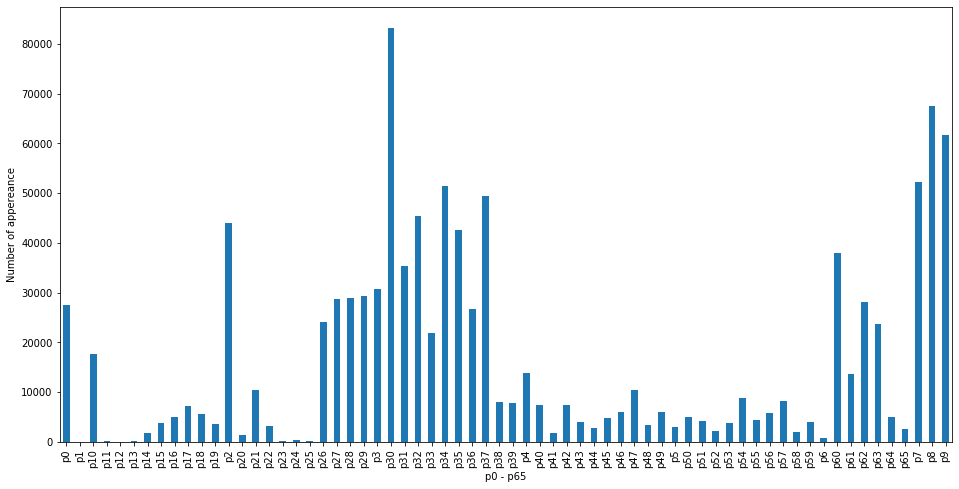

In [136]:
plt.figure(figsize=[16,8])  
df_p.sort_index().plot(kind = 'bar')
plt.xlabel('p0 - p65')
plt.ylabel('Number of appereance') 